In [1]:
import pandas as pd
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import NormalPredictor
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import KNNBaseline
from surprise import SVD
from surprise import BaselineOnly
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from surprise.accuracy import rmse
from surprise import accuracy
from surprise.model_selection import train_test_split

from decimal import Decimal, ROUND_HALF_UP

import csv

In [2]:
### companyIdappId.csv was obtained using the following SQL query

### SELECT company_id, app_editions.application_id FROM app_editions INNER JOIN 
###  (SELECT purchase_orders.company_id, app_edition_pricings.edition_id 
###  FROM purchase_orders INNER JOIN app_edition_pricings ON purchase_orders.edition_pricing_id = app_edition_pricings.id) AS fij
###  ON app_editions.id = fij.edition_id

with open('companyIDappId.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    new_dict = {}
    company_licenses = {}

    for row in csv_reader:
        companyId = row[0] 
        appId = row[1]
        if companyId in company_licenses:
            company_licenses[companyId] += 1
        else: 
            company_licenses[companyId] = 1

        if (companyId, appId) in new_dict:
            new_dict[(companyId, appId)] += 1
        else:
            new_dict[(companyId, appId)] = 1
        line_count += 1
    file = open("dataset","w+") 
    for (companyId, appId) in new_dict.keys(): 
        new_dict[(companyId, appId)] = (new_dict[(companyId, appId)] / company_licenses[companyId])
        file.write(str(companyId) + ',' + str(appId) + ',' + str(Decimal((new_dict[(companyId, appId)] * 5)).quantize(0, ROUND_HALF_UP)) + '\n')

In [3]:
df = pd.read_csv('dataset', sep=',', error_bad_lines=False, encoding="latin-1")
df.columns = ['companyID', 'productId', 'inferredRating']
df.head(15)

companyID  productId  inferredRating
0          17          3               5
1           6          3               3
2          30          3               3
3          12          3               1
4          11          3               2
5          11          7               3
6           3          7               2
7           2          9               3
8          12          7               5
9          30          7               3
10          1          9               1
11         99         12               5
12        166         12               5
13        138          9               5
14         13          7               5

In [4]:
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

data = df['inferredRating'].value_counts().sort_index(ascending=False)
trace = go.Bar(x = data.index,
               text = ['{:.1f} %'.format(val) for val in (data.values / df.shape[0] * 100)],
               textposition = 'auto',
               textfont = dict(color = '#000000'),
               y = data.values,
               )
# Create layout
layout = dict(title = 'Distribution Of {} product-ratings'.format(df.shape[0]),
              xaxis = dict(title = 'Rating'),
              yaxis = dict(title = 'Count'))
# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [5]:
# Number of ratings per company
data = df.groupby('companyID')['inferredRating'].count().clip(upper=50)

# Create trace
trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 50,
                                  size = 2))
# Create layout
layout = go.Layout(title = 'Distribution Of Number of Ratings Per Company (Clipped at 50)',
                   xaxis = dict(title = 'Ratings Per Company'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)


In [6]:
reader = Reader(rating_scale=(0, 9))
data = Dataset.load_from_df(df[['companyID', 'productId', 'inferredRating']], reader)

In [7]:
benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')  

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...


test_rmse  fit_time  test_time
Algorithm                                      
SVD               1.393792  0.070417   0.004374
KNNBaseline       1.405188  0.017765   0.008926
SVDpp             1.477513  0.210903   0.006043
BaselineOnly      1.496463  0.003261   0.003701
NMF               1.919383  0.153037   0.003998
KNNWithMeans      1.931324  0.021301   0.029507
KNNWithZScore     1.932458  0.042610   0.009573
SlopeOne          1.949127  0.011803   0.004350
CoClustering      1.962576  0.120127   0.003607
KNNBasic          1.965589  0.012929   0.007509
NormalPredictor   2.871344  0.001633   0.003994

In [8]:
print('Using ALS')
bsl_options = {'method': 'als',
               'n_epochs': 5,
               'reg_u': 12,
               'reg_i': 5
               }
algo = BaselineOnly(bsl_options=bsl_options)
cross_validate(algo, data, measures=['RMSE'], cv=3, verbose=False)

Using ALS
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


{'test_rmse': array([1.46849486, 1.45392447, 1.43694929]),
 'fit_time': (0.002675294876098633,
  0.0018351078033447266,
  0.002312898635864258),
 'test_time': (0.004075050354003906,
  0.003183126449584961,
  0.003997087478637695)}

In [9]:
trainset, testset = train_test_split(data, test_size=0.25)
algo = BaselineOnly(bsl_options=bsl_options)
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)


Estimating biases using als...
RMSE: 1.3892


1.3891830625921957

In [10]:
def get_Iu(uid):
    """ return the number of items rated by given user
    args: 
      uid: the id of the user
    returns: 
      the number of items rated by the user
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """ return number of users that have rated given item
    args:
      iid: the raw id of the item
    returns:
      the number of users that have rated the item.
    """
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0
    
df2 = pd.DataFrame(predictions, columns=['companyId', 'productId', 'rating', 'estimated_rating', 'details'])
df2['Iu'] = df2.companyId.apply(get_Iu)
df2['Ui'] = df2.productId.apply(get_Ui)
df2['err'] = abs(df2.estimated_rating - df2.rating)

In [11]:
df.head()

companyID  productId  inferredRating
0         17          3               5
1          6          3               3
2         30          3               3
3         12          3               1
4         11          3               2

In [12]:
best_predictions = df2.sort_values(by='err')[:10]
worst_predictions = df2.sort_values(by='err')[-10:]

In [13]:
best_predictions

companyId  productId  rating  estimated_rating  \
322       2026       2390     3.0          3.003138   
124       1987          9     4.0          4.034388   
286       1743         13     3.0          2.934843   
180         30          3     3.0          2.893783   
300       3111       2253     3.0          3.110840   
83        2305       1194     3.0          3.112192   
214       3919        892     3.0          3.113510   
26        1101        364     3.0          3.113510   
32        3872       3145     3.0          3.133008   
331       2557       1022     3.0          3.133008   

                       details  Iu   Ui       err  
322  {'was_impossible': False}   1    0  0.003138  
124  {'was_impossible': False}   1  161  0.034388  
286  {'was_impossible': False}   1   23  0.065157  
180  {'was_impossible': False}   1    4  0.106217  
300  {'was_impossible': False}   1    1  0.110840  
83   {'was_impossible': False}   1    1  0.112192  
214  {'was_impossible': False}   1    0  0.113510  
26   {'was_impossible': False}   1    0  0.113510  
32   {'was_impossible': False}   1    0  0.133008  
331  {'was_impossible': False}   1    0  0.133008

In [14]:
worst_predictions

companyId  productId  rating  estimated_rating  \
169        486          7     1.0          3.806751   
76        3593        112     1.0          3.861557   
194        786          9     1.0          3.920870   
9          789         47     0.0          2.923522   
232        587        114     5.0          2.054571   
24         611        365     0.0          2.996269   
275       1482          9     0.0          3.135762   
52        1745          9     1.0          4.215930   
198       3644        334     1.0          4.506037   
62        1129        373     0.0          3.603916   

                       details  Iu   Ui       err  
169  {'was_impossible': False}   4   68  2.806751  
76   {'was_impossible': False}   1   52  2.861557  
194  {'was_impossible': False}   2  161  2.920870  
9    {'was_impossible': False}   5   12  2.923522  
232  {'was_impossible': False}   0    8  2.945429  
24   {'was_impossible': False}   2    2  2.996269  
275  {'was_impossible': False}   8  161  3.135762  
52   {'was_impossible': False}   1  161  3.215930  
198  {'was_impossible': False}   0   28  3.506037  
62   {'was_impossible': False}   3    7  3.603916

In [15]:
df.loc[df['productId'] == 7]['inferredRating'].describe()

count    90.000000
mean      4.577778
std       1.091106
min       1.000000
25%       5.000000
50%       5.000000
75%       5.000000
max       5.000000
Name: inferredRating, dtype: float64

<IPython.core.display.Javascript object>


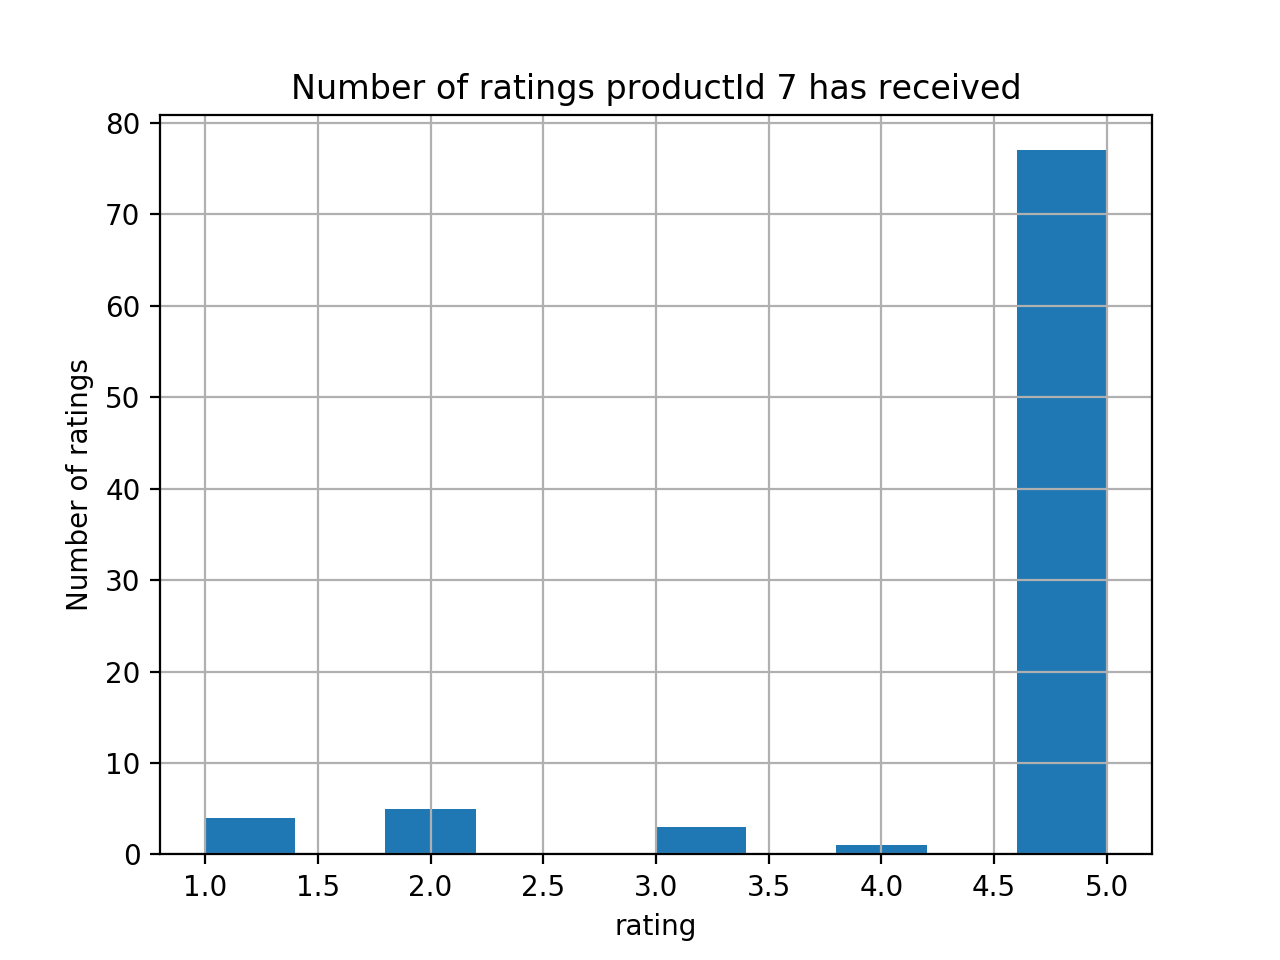

In [17]:
from collections import Counter

import matplotlib.pyplot as plt
import matplotlib
%matplotlib notebook

df.loc[df['productId'] == 7]['inferredRating'].hist()
plt.xlabel('rating')
plt.ylabel('Number of ratings')
plt.title('Number of ratings productId 7 has received')
plt.show();